# Random Behavior of ICNN in the Large Width Limit

Here is the mathematical definition of the ICNNs used in this document. *Note: the last layer activation function is linear*. 

$$
\begin{align}
    z_{i+1} & = \sigma ( A_{i} z_0 + W_{i} z_i + b_i ) \qquad i = 0, 1, \ldots, D-2 \\
    z_D & = A_{D-1} z_0 + W_{D-1} z_{D-1} + b_{D-1} \\
    f_{\theta}(z_0) & = z_D
\end{align}
$$
where $W_{i} \sim \text{Unif}([0, 0.1])$, $A_i \sim \mathcal{N}(0, 1)$, $b_i \sim \mathcal{N}(0, 1)$.

The layer widths are controlled by integers $\{k_i\}_{i=0}^{D}$ and the parameters are $A_i \in \mathbb{R}^{k_{i+1} \times k_0}$, $b_i \in \mathbb{R}^{k_{i+1}}$, and $W_i \in \mathbb{R}^{k_{i+1} \times k_i}_+$. Note that the matrices $A_i$ are unconstrained linear functions of the input $z_0$.

The definition of MLPs used in this document is the same but with all weights normally distributed.
$$
\begin{align}
    z_{i+1} & = \sigma ( A_{i} z_0 + W_{i} z_i + b_i ) \qquad i = 0, 1, \ldots, D-2 \\
    z_D & = A_{D-1} z_0 + W_{D-1} z_{D-1} + b_{D-1} \\
    f_{\theta}(z_0) & = z_D
\end{align}
$$
where $W_{i} \sim \mathcal{N}(0, 1)$, $A_i \sim \mathcal{N}(0, 1)$, $b_i \sim \mathcal{N}(0, 1)$.


**Notation**: some ICNNs in this page are written as "$(k_0, k_1, \ldots, k_d)$ ICNN" to denote layer input/output sizes. For example, a $(1, 3, 1)$ ICNN has two layers, the first mapping from 1 to 3 dimensions and the second mapping from 3 to 1 dimension.


In [4]:
print("Code cell...")
import torch
import torch.nn as nn
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from icnn.nets import ICNN, du_MLP, TParams

def netfit_by_width(net_type, width, fit_fn, tparams, interval=(-3, 3, 0.1), device="cpu"):
    '''
    Given a network type {mlp, icnn}, a desired network width, a function to fit, 
        and gradient descent training parameters, fit the function and return the
        difference in L2 of original weights to learned weights.
    '''
    if(net_type == "icnn"):
        net = ICNN("relu", (1, width, 1), scale=1/width, device="cpu")
    elif(net_type == "mlp"):
        net = du_MLP("relu", (1, width, 1), scale=1/np.sqrt(width), device="cpu")
    else:
        raise Exception("Unrecognized net type")
    
    def extract_weights(net_inst):
        weights = [np.copy(w.detach().cpu().numpy()) for w in net_inst.parameters()]
        return weights 
    
    initial_weights = extract_weights(net)
    net.train(fit_fn, interval[0], interval[1], interval[2], tparams, verbose=True)
    trained_weights = extract_weights(net)
    return np.max([np.max(np.abs(t-i)) for t, i in zip(trained_weights, initial_weights)])
    
def avg_netfit_by_width(n, net_type, width, fit_fn, tparams, interval=(-3, 3, 0.1)):
    return np.mean([netfit_by_width(net_type, width, fit_fn, tparams, interval) for _ in range(n)])

Code cell...


# Random Net Outputs

In [5]:
print("Code cell...")
def plot_random_mlp_samples(n, width, interval=(-5, 5, 0.1)):
    x_npy = np.arange(*interval)
    x = torch.tensor(x_npy, dtype=torch.double, device="cuda").view([-1, 1])
    mean = np.zeros((len(x_npy), 1))
    for i in range(n):
        net = du_MLP("relu", (1, width, 1), device="cuda", scale=1/np.sqrt(width))
        y = net.forward(x).detach().cpu().numpy()
        plt.plot(x_npy, y)
        mean += y
    mean = mean / n
    plt.plot(x_npy, mean, "r--", linewidth="3", label="Mean")
        
def plot_random_icnn_samples(n, width, interval=(-5, 5, 0.1)):
    x_npy = np.arange(*interval)
    x = torch.tensor(x_npy, dtype=torch.double, device="cuda").view([-1, 1])
    mean = np.zeros((len(x_npy), 1))
    for i in range(n):
        net = ICNN("relu", (1, width, 1), device="cuda", scale=1/width)
        y = net.forward(x).detach().cpu().numpy()
        plt.plot(x_npy, y)
        mean += y
    mean = mean / n
    plt.plot(x_npy, mean, "r--", linewidth="3", label="Mean")

Code cell...


This plot shows the network function for randomly initialized two layer MLPs and ICNNs mapping from $\mathbb{R}$ to $\mathbb{R}$. 

The first row is a two layer MLP with bias on the first layer.
$$
\begin{align*}
    \rho(x) = \frac{1}{\sqrt{m}}\sum_{r=1}^m w^{(2)}_r \sigma (w^{(1)}_r x + b_r)
\end{align*}
$$
where $w, b \sim \mathcal{N}(0, 1)$ and $\sigma(x) = \max(0, x)$ is a ReLU function.


The second row is a two layer ICNN.
$$
\begin{align*}
    \phi(x) = \frac{1}{m}\left( a^{(2)} x + \sum_{r=1}^m w^{(2)}_r \sigma(w^{(1)}_r x + a^{(1)} x + b^{(1)}_r) + b^{(2)} \right)
\end{align*}
$$
where $a, b \sim \mathcal{N}(0, 1)$ and $w \sim \text{Unif}([0, 0.1])$. 


**Takeaway**: as the width grows, the random ICNN converges to a particular function. The appropriate scaling for its outputs to remain $O(1)$ is $1/m$, where the appropriate scaling for MLPs is $1/\sqrt{m}$. 

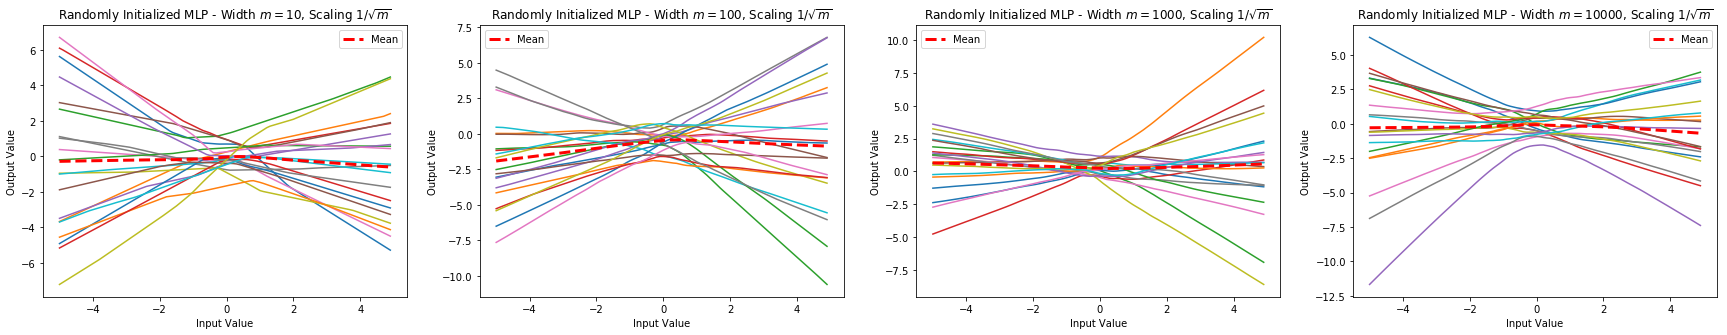

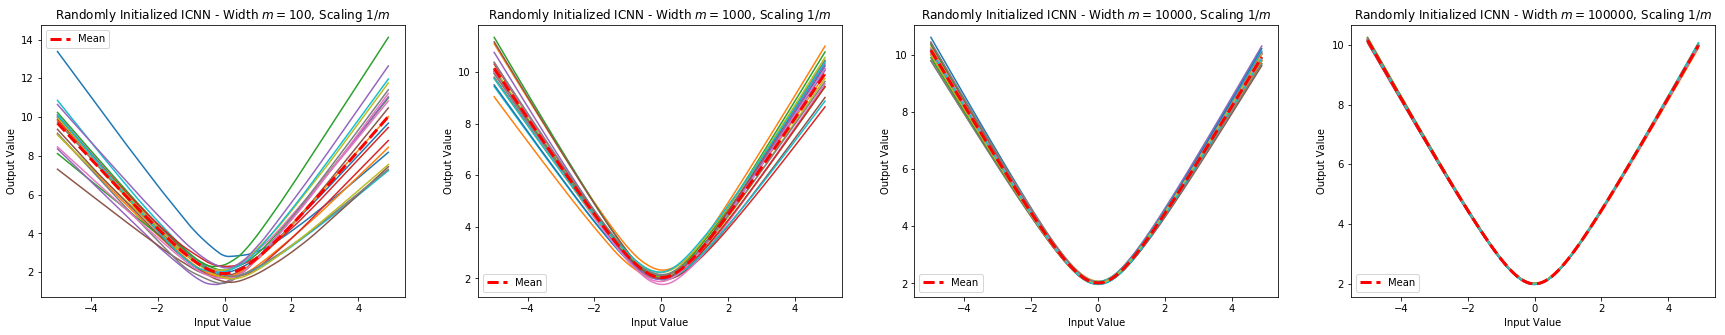

In [6]:
for i in range(1, 5):
    plt.subplot(1, 4, i)
    plot_random_mlp_samples(20, 10**i)
    plt.title(f"Randomly Initialized MLP - Width $m={10**i}$," r" Scaling $1/\sqrt{m}$")
    plt.xlabel("Input Value")
    plt.ylabel("Output Value")
    plt.legend()
plt.gcf().set_size_inches(30, 5)
plt.show()

for i in range(2, 6):
    plt.subplot(1, 4, i-1)
    plot_random_icnn_samples(20, 10**i)
    plt.title(f"Randomly Initialized ICNN - Width $m={10**i}$, Scaling $1/m$")
    plt.xlabel("Input Value")
    plt.ylabel("Output Value")
    plt.legend()

plt.gcf().set_size_inches(30, 5)
plt.show()

# Weight Change During Learning

This section is WIP. It is indended to ask whether these nets undergo lazy learning, where the change in each weight over training is diminished as the width grows large. This does not currently bear out experimentally.

In [ ]:
t = TParams(0.01, 0.9, 0.9, 1000)

widths = np.arange(1, 200, 25)**2
fit_fn = lambda x: x**2

mlp_weight_change = [avg_netfit_by_width(1, "mlp", w, fit_fn, t) for w in widths]
icnn_weight_change = [avg_netfit_by_width(1, "icnn", w, fit_fn, t) for w in widths]

In [ ]:
plt.plot(widths, mlp_weight_change, label="MLP")
plt.plot(widths, icnn_weight_change, label="ICNN")
plt.title("Maximum deviation of any weight during training")
plt.xlabel("Network Width")
plt.ylabel("$|w_{old} - w_{new}|_{\infty}$")
plt.legend()
plt.savefig("weight_deviation_training.pdf", dpi=120)